## California Housing Prices Regression Analysis

### Load the dataset

In [1]:
import pandas as pd

# Load the dataset
housing_data = pd.read_csv('housing.csv')

# Display the first few rows of the dataset
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Anlaysis

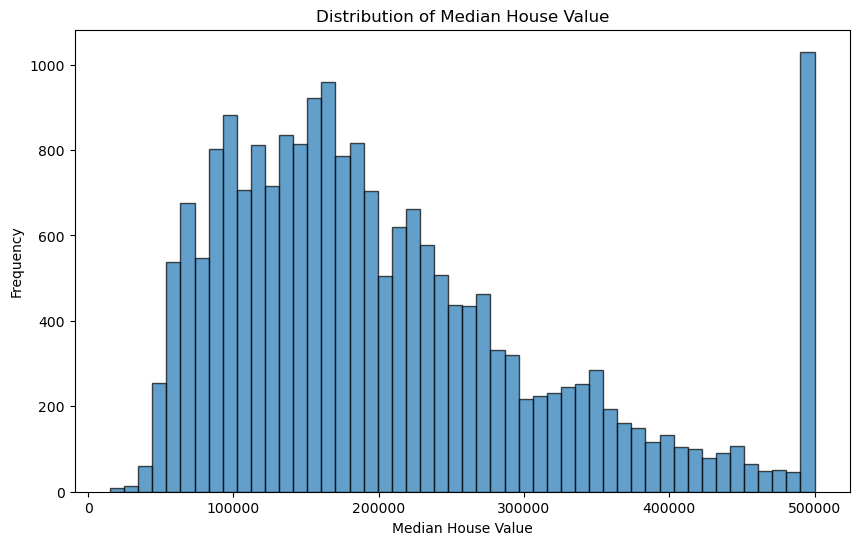

In [2]:
import matplotlib.pyplot as plt

#Plot the distribution of the 'median_house_value' column
plt.figure(figsize=(10,6))
plt.hist(housing_data['median_house_value'],bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

### Preparing the Dataset

In [3]:
filtered_data = housing_data[housing_data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
columns_to_keep = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]
filtered_data = filtered_data[columns_to_keep]
filtered_data.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question1: One feature with missing values

In [4]:
# Identify columns with missing values
missing_values = filtered_data.isnull().sum()
missing_column = missing_values[missing_values > 0].index[0]
missing_column

'total_bedrooms'

The feature with missing values is <strong>total_bedrooms</strong>

### Question2: The median (50% percentile) for variable 'population'

In [7]:
# Calculate the median for the 'population' column
population_median = filtered_data['population'].median()
population_median

1195.0

The median 50th percentile for the variable 'population' is **1195**

### Prepare and Split the Dataset

In [17]:
from sklearn.model_selection import train_test_split
import numpy as np

# Shuffle and split the dataset
np.random.seed(42)
shuffled_data = filtered_data.sample(frac=1, random_state=42)

# Splitting into train/val/test sets
train, temp = train_test_split(shuffled_data, test_size=0.4, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Apply log transformation to 'median_house_value'
train['median_house_value'] = np.log1p(train['median_house_value'])
val['median_house_value'] = np.log1p(val['median_house_value'])
test['median_house_value'] = np.log1p(test['median_house_value'])

train.shape, val.shape, test.shape


((9412, 9), (3137, 9), (3138, 9))

### Question 3:LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define a function to train and evaluate a linear regression model
def train_and_evaluate(X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

# Prepare features and target for train and val sets
X_train = train.drop(columns=['median_house_value'])
y_train = train['median_house_value']
X_val = val.drop(columns=['median_house_value'])
y_val = val['median_house_value']

# Fill missing values with 0
X_train_zero = X_train.fillna(0)
X_val_zero = X_val.fillna(0)
rmse_zero = train_and_evaluate(X_train_zero, y_train, X_val_zero, y_val)

# Fill missing values with mean
mean_value = X_train['total_bedrooms'].mean()
X_train_mean = X_train.fillna(mean_value)
X_val_mean = X_val.fillna(mean_value)
rmse_mean = train_and_evaluate(X_train_mean, y_train, X_val_mean, y_val)

rmse_zero, rmse_mean


(0.3464608098444538, 0.3462097108527321)

Filling with the **mean** provides a better RMSE

### Question4: Regularized linear regression

In [21]:
from sklearn.linear_model import Ridge

# Define a function to train and evaluate a Ridge regression model
def train_and_evaluate_ridge(X_train, y_train, X_val, y_val, alpha):
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

# List of r values to test
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

# Evaluate Ridge regression for different r values
rmse_scores = {}
for r in r_values:
    rmse = train_and_evaluate_ridge(X_train_zero, y_train, X_val_zero, y_val, r)
    rmse_scores[r] = round(rmse, 2)

# Determine the r value with the smallest RMSE
best_r = min(rmse_scores, key=rmse_scores.get)
best_r, rmse_scores


(0,
 {0: 0.35,
  1e-06: 0.35,
  0.0001: 0.35,
  0.001: 0.35,
  0.01: 0.35,
  0.1: 0.35,
  1: 0.35,
  5: 0.35,
  10: 0.35})

The smallest **RMS** value that achieves the best RMSE is r=0.

### Question 5:Testing with different splits

In [25]:

seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores_seeds_corrected = []

def split_data_seed(seed, data):
    train, temp = train_test_split(data, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

for seed in seed_values:
    train_seed, val_seed, test_seed = split_data_seed(seed, shuffled_data)
    train_seed['median_house_value'] = np.log1p(train_seed['median_house_value'])
    val_seed['median_house_value'] = np.log1p(val_seed['median_house_value'])
    
    X_train_seed = train_seed.drop(columns=['median_house_value']).fillna(0)
    y_train_seed = train_seed['median_house_value']
    X_val_seed = val_seed.drop(columns=['median_house_value']).fillna(0)
    y_val_seed = val_seed['median_house_value']
    
    rmse = train_and_evaluate(X_train_seed, y_train_seed, X_val_seed, y_val_seed)
    rmse_scores_seeds_corrected.append(rmse)

std_rmse_corrected = round(np.std(rmse_scores_seeds_corrected), 3)
std_rmse_corrected
    

0.006

The standard deviation of the RMSE scores across different seeds is 
**0.006**.

### Question6: With seed=9

In [26]:
# Split data using seed 9
train_seed_9, val_seed_9, test_seed_9 = split_data_seed(9, shuffled_data)

# Combine train and validation datasets
combined_train = pd.concat([train_seed_9, val_seed_9])

# Prepare features and target for combined_train and test
X_train_combined = combined_train.drop(columns=['median_house_value']).fillna(0)
y_train_combined = np.log1p(combined_train['median_house_value'])
X_test_seed_9 = test_seed_9.drop(columns=['median_house_value']).fillna(0)
y_test_seed_9 = np.log1p(test_seed_9['median_house_value'])

# Train Ridge regression model with r=0.001 and evaluate on test set
rmse_test = train_and_evaluate_ridge(X_train_combined, y_train_combined, X_test_seed_9, y_test_seed_9, 0.001)
round(rmse_test, 2)


0.34

The RMSE on the test dataset is **0.34**